In [61]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install statsmodels


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### 1. 데이터 로드 및 구조 확인

In [63]:
iris = sns.load_dataset('iris')

In [64]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [65]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### 2. 기술통계량

In [66]:
iris.groupby('species')['petal_length'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,50.0,1.462,0.173664,1.0,1.4,1.50,1.575,1.9
versicolor,50.0,4.260,0.469911,3.0,4.0,4.35,4.600,5.1
virginica,50.0,5.552,0.551895,4.5,5.1,5.55,5.875,6.9


### 3. 시각화

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


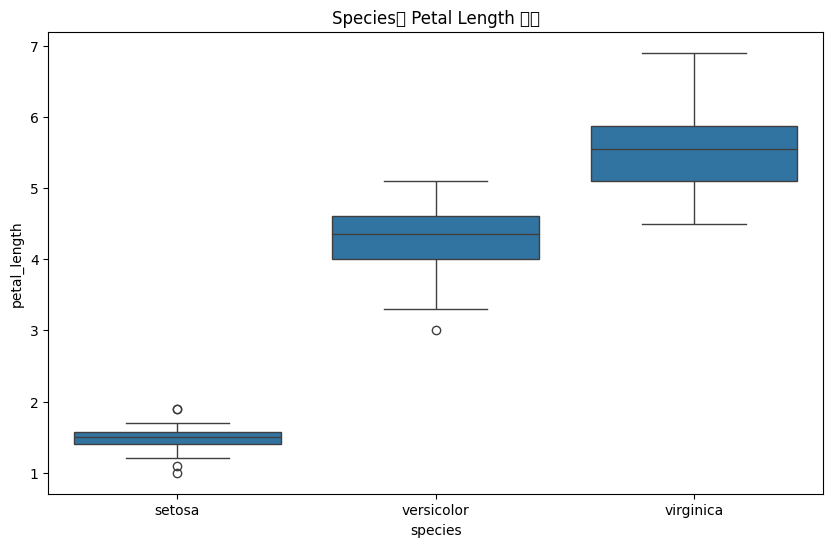

In [67]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'species', y = 'petal_length', data = iris)
plt.title('Species별 Petal Length 분포')
plt.show()

### 4. 정규성 검정(Shapiro-Wilk)

- H_0: 데이터가 정규분포를 따른다.
- H_1: 데이터가 정규분포를 따르지 않는다.

In [68]:
species_list = iris['species'].unique()

for species in species_list:
    data = iris[iris['species'] == species]['petal_length']
    stat, p_val = stats.shapiro(data)
    print(f"Species: {species:10} | Statistic: {stat:.4f}, p-value: {p_val:.4f}")

    if p_val > 0.05:
        print(f"\np > 0.05 이므로 정규성 만족 (귀무가설 채택)\n")
    else:
        print(f"\np <= 0.05 이므로 정규성 위배 (귀무가설 기각)(but, 이후 분석은 정규성 만족 가정)\n")

Species: setosa     | Statistic: 0.9550, p-value: 0.0548

p > 0.05 이므로 정규성 만족 (귀무가설 채택)

Species: versicolor | Statistic: 0.9660, p-value: 0.1585

p > 0.05 이므로 정규성 만족 (귀무가설 채택)

Species: virginica  | Statistic: 0.9622, p-value: 0.1098

p > 0.05 이므로 정규성 만족 (귀무가설 채택)



### 5. 등분산성 검정(Levene)

- H_0: 세 그룹의 분산은 동일하다.
- H_1: 적어도 한 그룹의 분산은 다르다.

In [69]:
setosa = iris[iris['species'] == 'setosa']['petal_length']
versicolor = iris[iris['species'] == 'versicolor']['petal_length']
virginica = iris[iris['species'] == 'virginica']['petal_length']

stat, p_val = stats.levene(setosa, versicolor, virginica)

print(f"Statistic: {stat:.4f}, p-value: {p_val:.4e}")

if p_val > 0.05:
    print("\np > 0.05 이므로 등분산성 만족 (귀무가설 채택)")
else:
    print("\np <= 0.05 이므로 등분산성 위배 (귀무가설 기각)(but, 이후 분석은 등분산성 만족 가정)")

Statistic: 19.4803, p-value: 3.1288e-08

p <= 0.05 이므로 등분산성 위배 (귀무가설 기각)(but, 이후 분석은 등분산성 만족 가정)


### 6. ANOVA 가설 수립

- H_0: 세 Species(setosa, versicolor, virginica) 간 Petal Length의 평균 차이는 없다.
- H_1: 적어도 한 Species의 Petal Length 평균은 다른 Species와 다르다.

### 7. One-way ANOVA

In [70]:
f_stat, p_val = stats.f_oneway(setosa, versicolor, virginica)

print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

if p_val > 0.05:
    print("\np-value > 0.05 이므로 통계적으로 유의미한 평균 차이 없음 (귀무가설 채택)")
else:
    print("\np-value <= 0.05 이므로 통계적으로 유의미한 평균 차이 있음 (귀무가설 기각) -> Tukey HSD 사후검정 실시")

F-statistic: 1180.1612, p-value: 2.8568e-91

p-value <= 0.05 이므로 통계적으로 유의미한 평균 차이 있음 (귀무가설 기각) -> Tukey HSD 사후검정 실시


### 8. 사후검정 (Tukey HSD)

In [71]:
tukey = pairwise_tukeyhsd(endog = iris['petal_length'], groups = iris['species'], alpha = 0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor    2.798   0.0 2.5942 3.0018   True
    setosa  virginica     4.09   0.0 3.8862 4.2938   True
versicolor  virginica    1.292   0.0 1.0882 1.4958   True
---------------------------------------------------------


### 9. 결과 요약

One-way ANOVA 결과, p-value가 0.05보다 작으므로, species별 Petal Length의 평균에는 통계적으로 유의미한 차이가 있다고 할 수 있다.
사후검정(Tukey HSD) 결과, Setosa, Versicolor, Virginica 모든 그룹 쌍 사이에서 유의미한 차이가 확인되었다.
Boxplot과 평균값을 종합해보면 Virginica > Versicolor > Setosa 순으로 Petal Length 차이가 난다는 결론을 내릴 수 있다.

### 10. 회귀 분석

In [73]:
X = iris[['sepal_length', 'sepal_width', 'petal_width']]
y = iris['petal_length']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("==========회귀 계수 & 절편==========")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

MSE: 0.1300
R² Score: 0.9603
==========회귀 계수 & 절편==========
sepal_length: 0.7228
sepal_width: -0.6358
petal_width: 1.4675
Intercept: -0.2622
